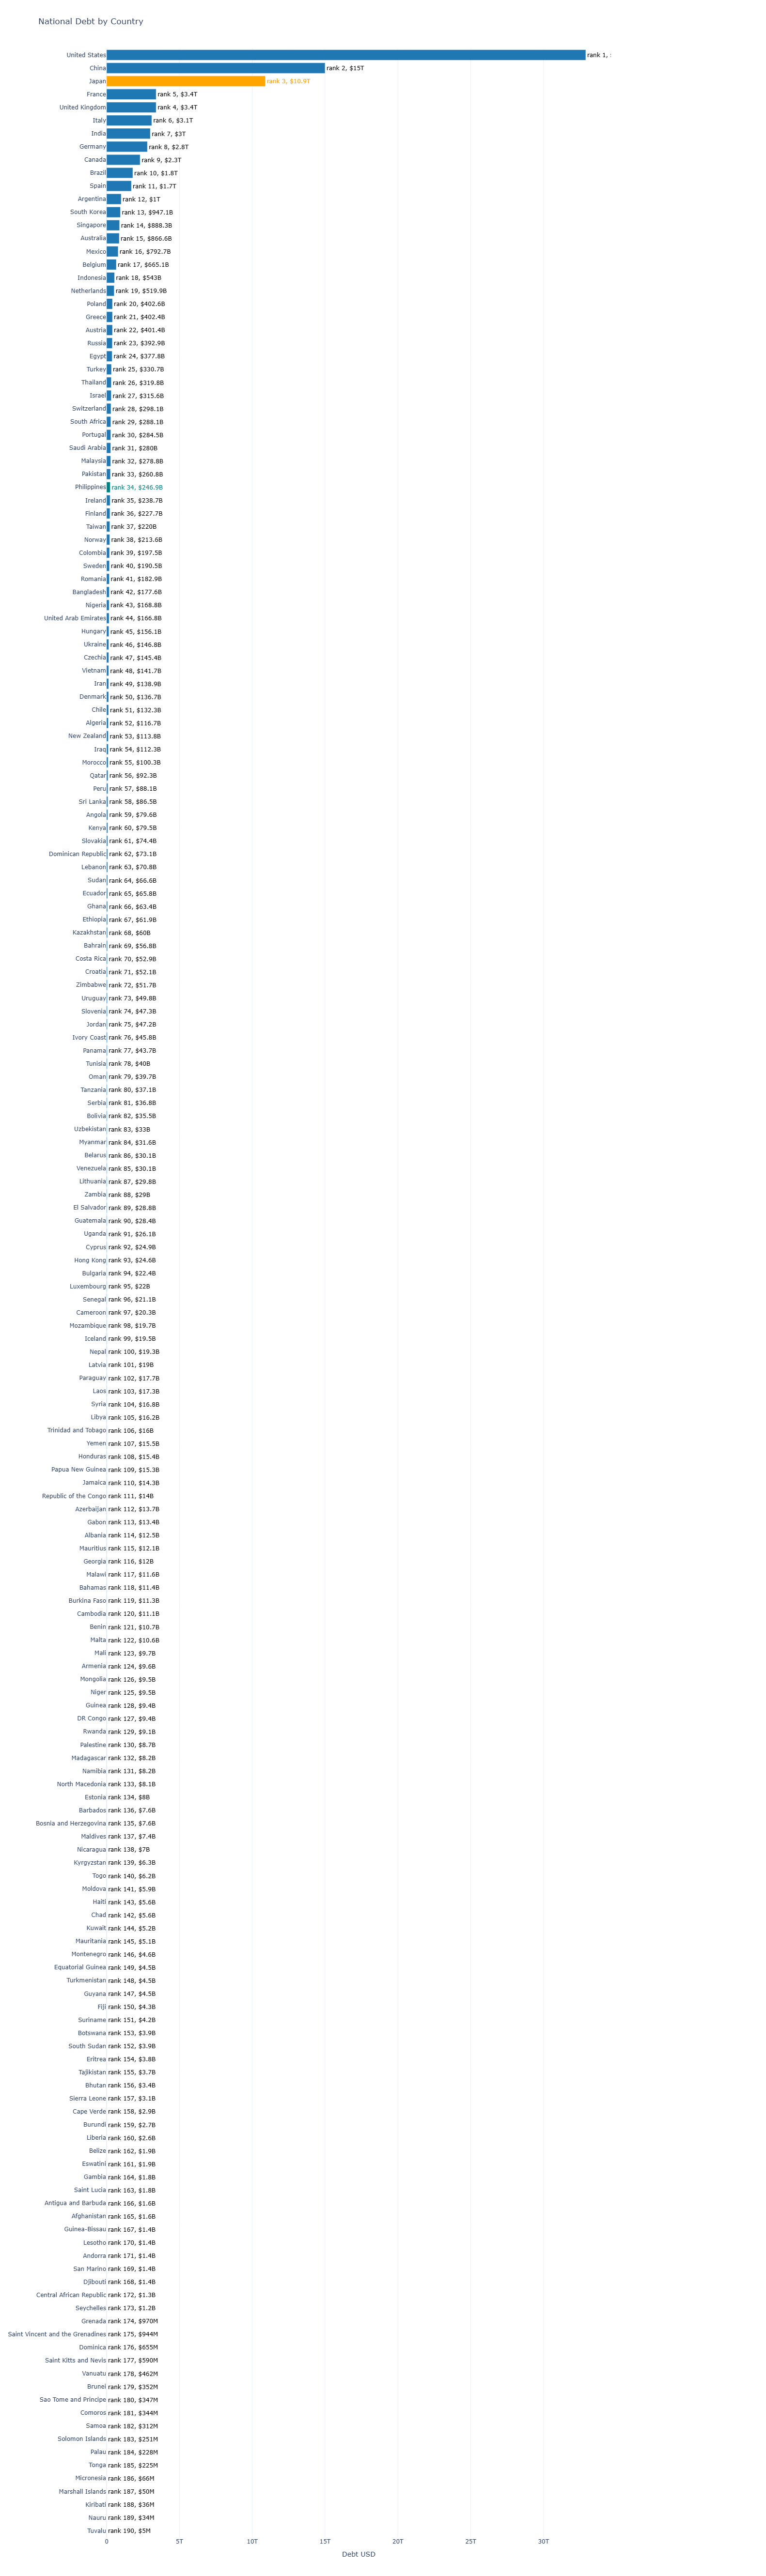

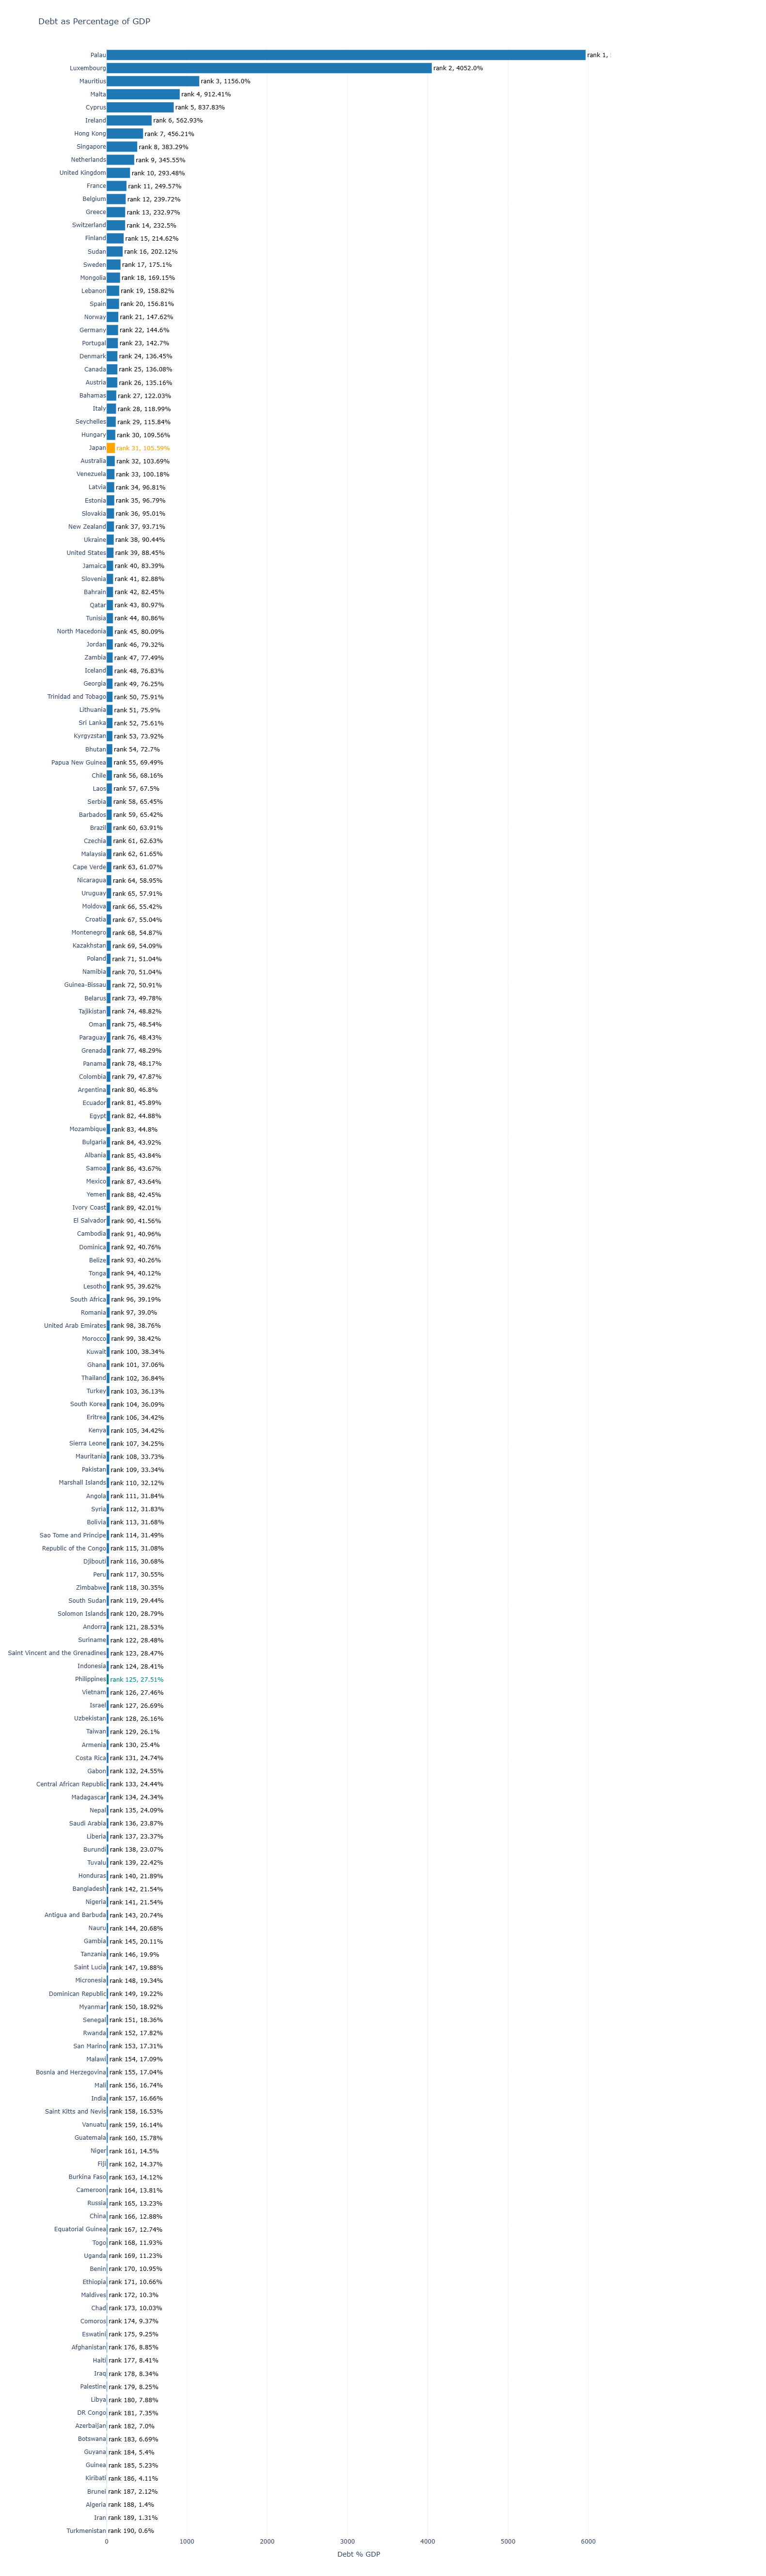

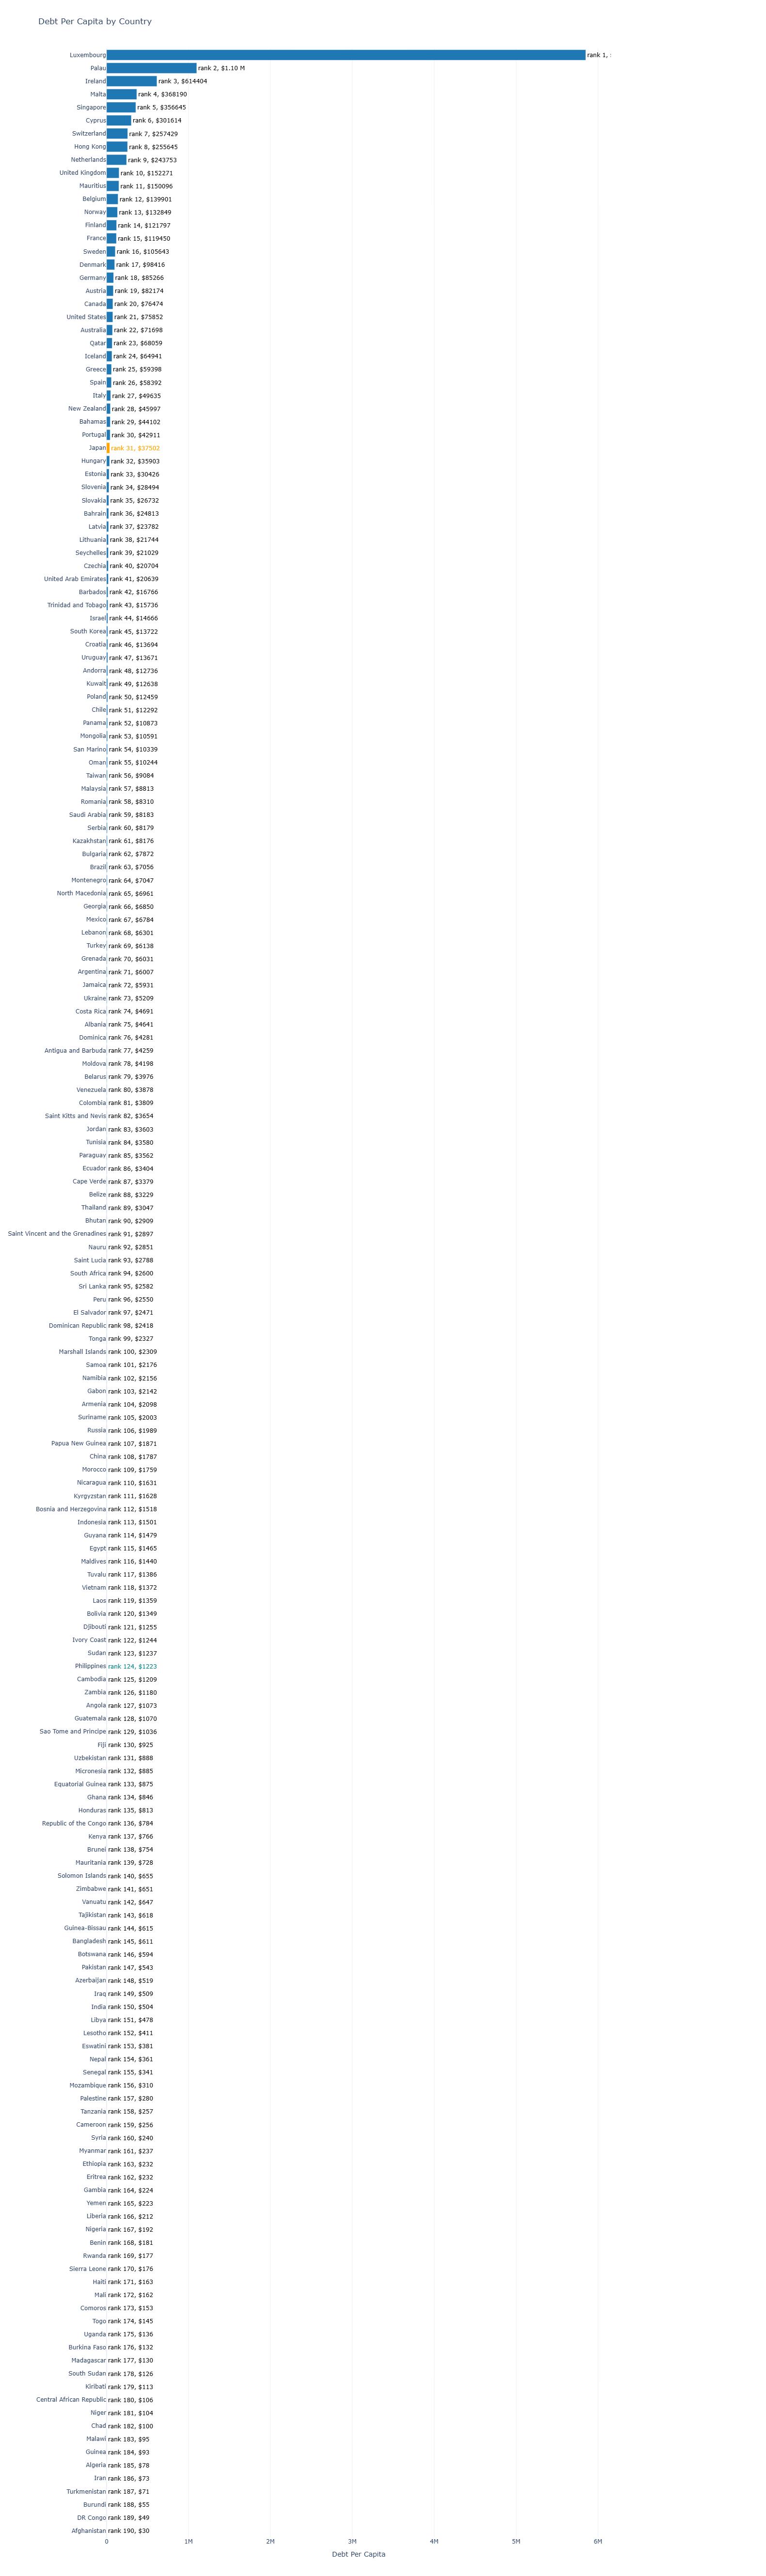

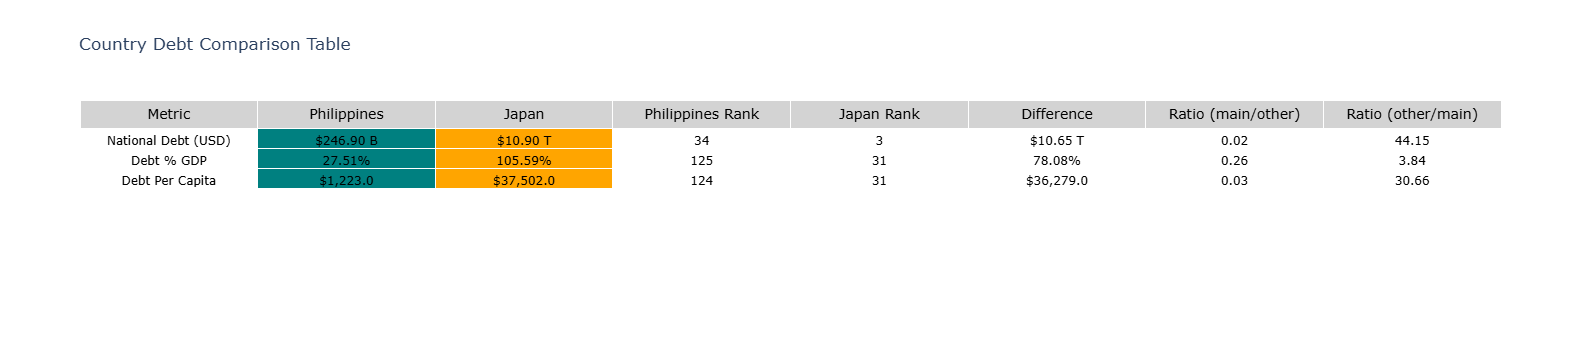

The Narrative and Comparison Statements

Out of 190 countries, two countries are compared: Philippines and Japan in terms of Debt Profiles.

National Debt (USD) represents the total debt of a country in US Dollars.
Debt % GDP shows the ratio of national debt to the country's GDP, indicating debt burden.
Debt Per Capita indicates the average debt per person in the country.


Philippines has a national debt of $246.90 B (Rank 34), which is 27.51%% of its GDP (Rank 125), and a per capita debt of $1,223.0 (Rank 124).

Japan has a national debt of $10.90 T (Rank 3), which is 105.59%% of its GDP (Rank 31), and a per capita debt of $37,502.0 (Rank 31).

For National Debt (USD), Philippines has $246.90 B (Rank 34), which is 0.02× of Japan's $10.90 T (Rank 3).
On the other hand, Japan is 44.15× bigger than Philippines.

For Debt % GDP, Philippines has 27.51% (Rank 125), which is 0.26× of Japan's 105.59% (Rank 31).
On the other hand, Japan is 3.84× bigger than Philippines.

For Debt Per Capita, 

C:\Users\User\AppData\Local\Temp\ipykernel_7436\4089915765.py:313: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



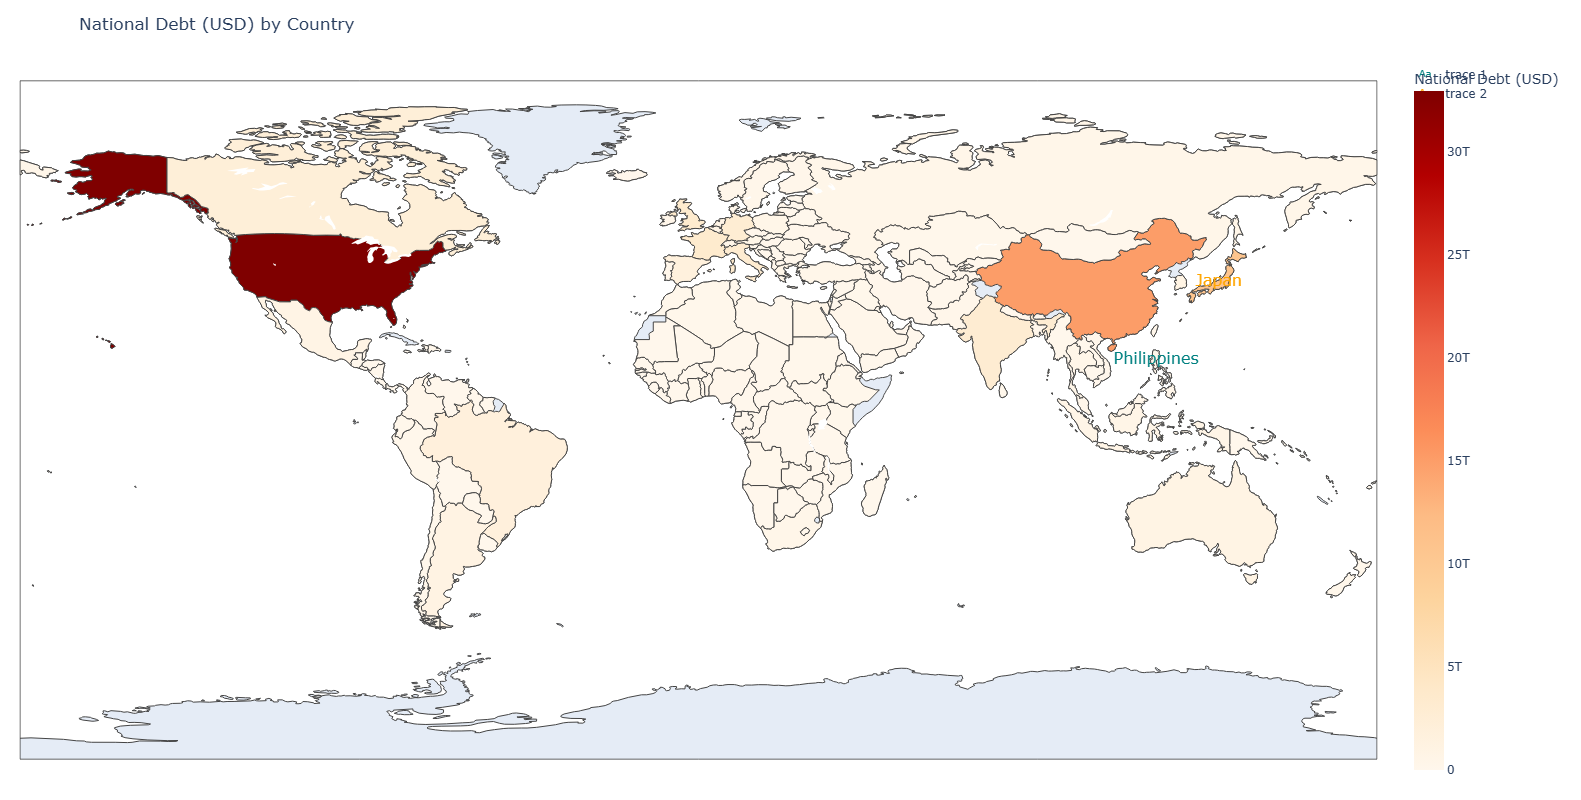

C:\Users\User\AppData\Local\Temp\ipykernel_7436\4089915765.py:329: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



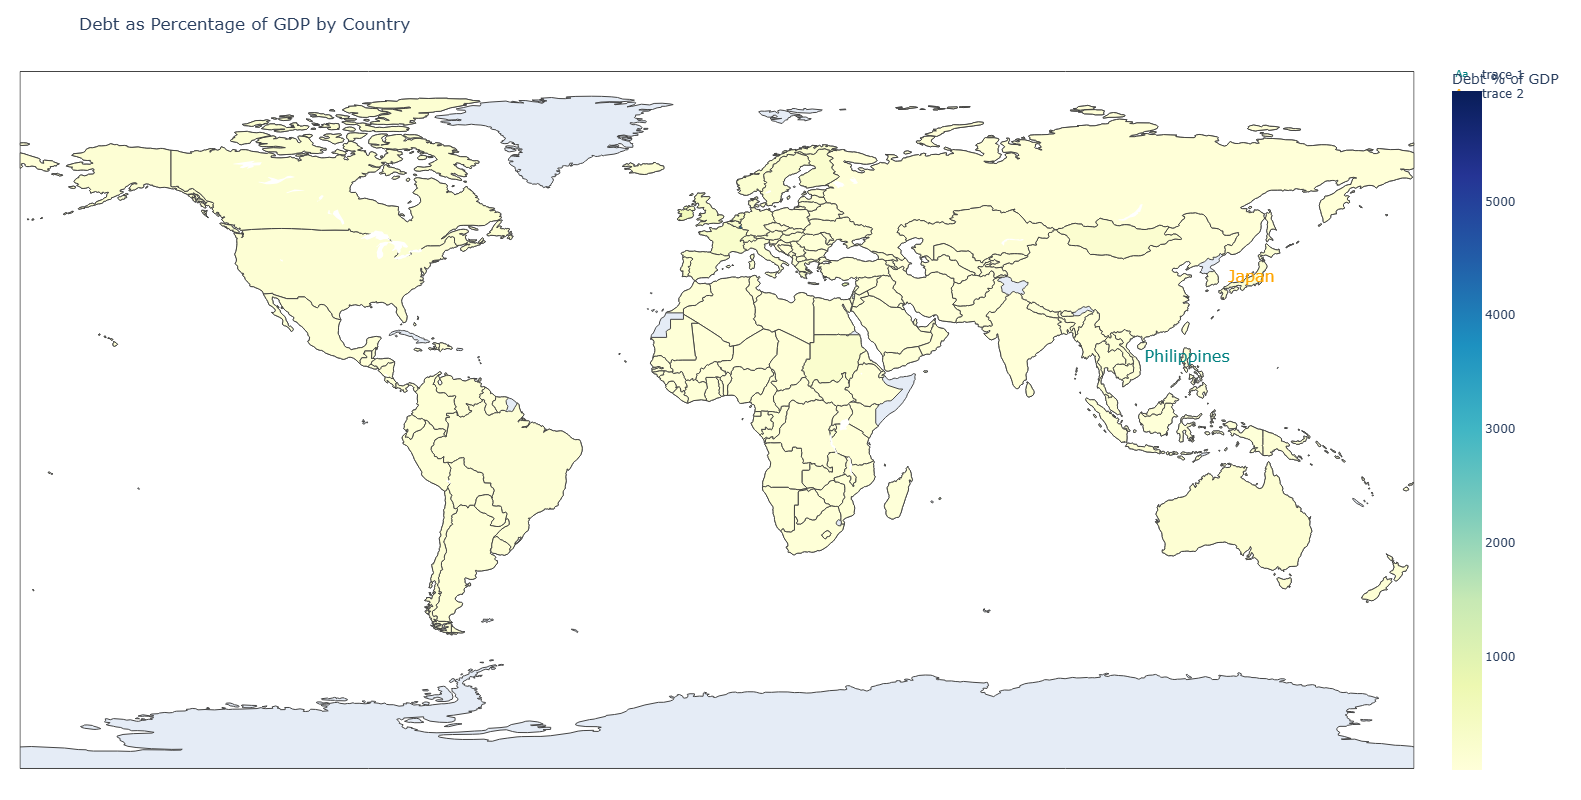

C:\Users\User\AppData\Local\Temp\ipykernel_7436\4089915765.py:345: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



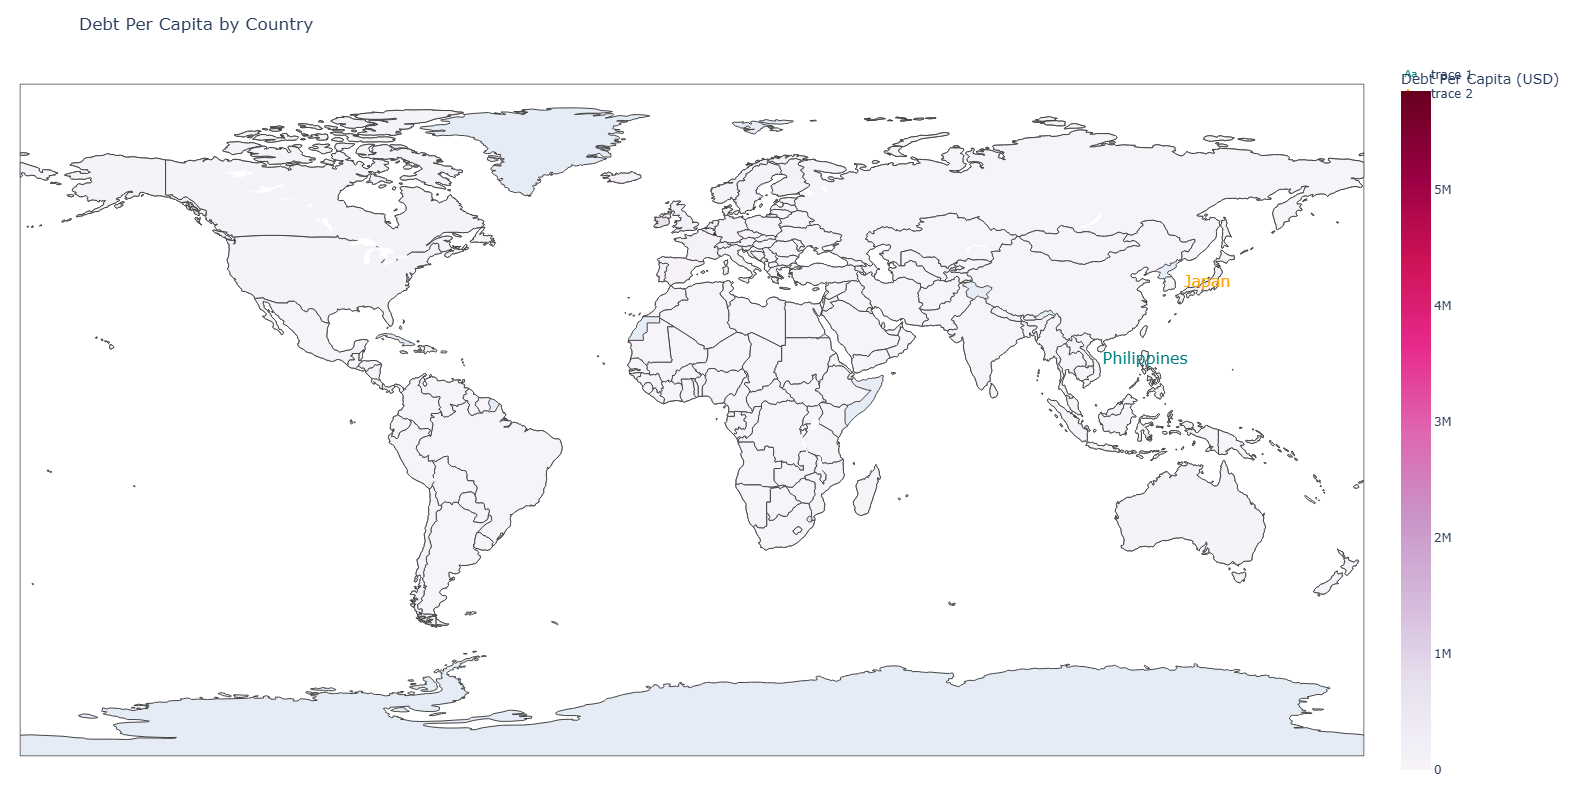

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import re

# USER INPUT
# Specify the main country and highlight country for visualization
USER_COUNTRY = "Philippines"  # this will be colored teal
USER_COLOR = "teal"

HIGHLIGHT_COUNTRY = "Japan"  # this will be colored orange
HIGHLIGHT_COLOR = "orange"

# FETCH NATIONAL DEBT DATA
# We are getting the table from the website that lists countries by national debt
url = "https://worldpopulationreview.com/country-rankings/countries-by-national-debt"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")
table = soup.find("table")
rows = table.find_all("tr")[1:]  # skip the header row

# Conversion factors for debt values
DEBT_MULT = {"T": 1e12, "B": 1e9, "M": 1e6}
records = []

# Loop through each row and extract country data
for row in rows:
    cols = row.find_all("td")
    if len(cols) < 5:
        continue
    country = cols[1].text.strip()
    if country.upper() == "TOTAL":  # skip aggregate row
        continue
    debt_text = cols[2].text.strip()
    gdp_pct_text = cols[3].text.strip()
    per_capita_text = cols[4].text.strip()

    # Parse the debt value in USD
    m = re.match(r"\$(\d+(\.\d+)?)([TBM])", debt_text)
    if not m:
        continue
    debt_val = float(m.group(1))
    debt_unit = m.group(3)
    debt_usd = int(debt_val * DEBT_MULT[debt_unit])

    # Parse debt as % of GDP
    debt_pct_gdp = float(gdp_pct_text.replace("%", "")) if "%" in gdp_pct_text else None

    # Parse debt per capita
    per_capita = None
    pc_text = per_capita_text.replace("$", "").replace(",", "").strip()
    pc_match = re.match(r"(\d+(\.\d+)?)\s*(Mn|Bn)?", pc_text)
    if pc_match:
        pc_val = float(pc_match.group(1))
        pc_unit = pc_match.group(3)
        if pc_unit == "Mn":
            per_capita = int(pc_val * 1_000_000)
        elif pc_unit == "Bn":
            per_capita = int(pc_val * 1_000_000_000)
        else:
            per_capita = int(pc_val)

    # Store the cleaned data
    records.append({
        "Country": country,
        "Debt Label": debt_text,
        "Debt USD": debt_usd,
        "Debt % GDP": debt_pct_gdp,
        "Debt Per Capita": per_capita
    })

# Create a DataFrame with all the countries
df = pd.DataFrame(records)

# HELPER FUNCTIONS
# This function sorts the countries and creates labels for plotting
def create_rank_labels(df, value_col, value_format="raw"):
    df_sorted = df.sort_values(value_col, ascending=False).reset_index(drop=True)
    df_sorted["Rank"] = df_sorted.index + 1

    def format_value(row):
        # Format the value based on type: debt, percentage, or per capita
        if value_format == "debt":
            return f"{row['Debt Label']}"
        elif value_format == "pct":
            return f"{row[value_col]}%"
        elif value_format == "percap":
            val = row[value_col]
            if val >= 1e9:
                return f"${val/1e9:.2f} B"
            elif val >= 1e6:
                return f"${val/1e6:.2f} M"
            else:
                return f"${val}"
        else:
            return str(row[value_col])

    df_sorted["Plot Label"] = df_sorted.apply(
        lambda x: f"rank {x['Rank']}, {format_value(x)}", axis=1
    )
    return df_sorted.sort_values(value_col)

# Function to assign colors to bars for user and highlighted country
def build_bar_colors(df, country_col="Country", user_country=None, user_color=None,
                     extra_country=None, extra_color=None):
    colors = []
    for c in df[country_col]:
        if user_country and c == user_country:
            colors.append(user_color)
        elif extra_country and c == extra_country:
            colors.append(extra_color)
        else:
            colors.append("#1f77b4")  # default blue for other countries
    return colors

# Function to assign text colors similarly
def build_text_colors(df, country_col="Country", user_country=None, user_color=None,
                     extra_country=None, extra_color=None):
    colors = []
    for c in df[country_col]:
        if user_country and c == user_country:
            colors.append(user_color)
        elif extra_country and c == extra_country:
            colors.append(extra_color)
        else:
            colors.append("black")
    return colors

# Format numbers with proper units for display
def format_value_units(val, metric):
    if metric == "Debt % GDP":
        return f"{val}%"
    elif metric in ["National Debt (USD)", "Debt Per Capita"]:
        if val >= 1e12:
            return f"${val/1e12:.2f} T"
        elif val >= 1e9:
            return f"${val/1e9:.2f} B"
        elif val >= 1e6:
            return f"${val/1e6:.2f} M"
        else:
            return f"${val:,}"
    return val

# Retrieve rank for a given country and metric
def get_rank(df_sorted, country):
    row = df_sorted[df_sorted["Country"]==country]
    return int(row["Rank"].iloc[0]) if not row.empty else None

# PLOT BAR CHARTS
# Prepare the data for each type of chart
df1_plot = create_rank_labels(df, "Debt USD", "debt")
df2_plot = create_rank_labels(df.dropna(subset=["Debt % GDP"]), "Debt % GDP", "pct")
df3_plot = create_rank_labels(df.dropna(subset=["Debt Per Capita"]), "Debt Per Capita", "percap")

bar_charts = [
    ("National Debt by Country", "Debt USD", df1_plot),
    ("Debt as Percentage of GDP", "Debt % GDP", df2_plot),
    ("Debt Per Capita by Country", "Debt Per Capita", df3_plot)
]

# Generate bar charts with proper coloring and labels
for title, val_col, plot_df in bar_charts:
    fig = go.Figure(go.Bar(
        x=plot_df[val_col],
        y=plot_df["Country"],
        orientation="h",
        text=plot_df["Plot Label"],
        textposition="outside",
        marker=dict(
            color=build_bar_colors(plot_df, user_country=USER_COUNTRY, user_color=USER_COLOR,
                                   extra_country=HIGHLIGHT_COUNTRY, extra_color=HIGHLIGHT_COLOR)
        ),
        textfont=dict(
            color=build_text_colors(plot_df, user_country=USER_COUNTRY, user_color=USER_COLOR,
                                    extra_country=HIGHLIGHT_COUNTRY, extra_color=HIGHLIGHT_COLOR)
        )
    ))
    fig.update_layout(
        title=title,
        xaxis_title=val_col,
        height=max(600, len(plot_df)*28),  # make sure height adjusts for number of countries
        margin=dict(l=220, r=320),
        template="plotly_white"
    )
    fig.show()

# CREATE SUMMARY DATAFRAME
# This table summarizes the debt metrics and ranks for the two countries
summary_data = {
    "Metric": ["National Debt (USD)", "Debt % GDP", "Debt Per Capita"],
    USER_COUNTRY: [
        int(df1_plot[df1_plot["Country"]==USER_COUNTRY]["Debt USD"].iloc[0]),
        float(df2_plot[df2_plot["Country"]==USER_COUNTRY]["Debt % GDP"].iloc[0]),
        int(df3_plot[df3_plot["Country"]==USER_COUNTRY]["Debt Per Capita"].iloc[0])
    ],
    HIGHLIGHT_COUNTRY: [
        int(df1_plot[df1_plot["Country"]==HIGHLIGHT_COUNTRY]["Debt USD"].iloc[0]),
        float(df2_plot[df2_plot["Country"]==HIGHLIGHT_COUNTRY]["Debt % GDP"].iloc[0]),
        int(df3_plot[df3_plot["Country"]==HIGHLIGHT_COUNTRY]["Debt Per Capita"].iloc[0])
    ],
    f"{USER_COUNTRY} Rank": [
        get_rank(df1_plot, USER_COUNTRY),
        get_rank(df2_plot, USER_COUNTRY),
        get_rank(df3_plot, USER_COUNTRY)
    ],
    f"{HIGHLIGHT_COUNTRY} Rank": [
        get_rank(df1_plot, HIGHLIGHT_COUNTRY),
        get_rank(df2_plot, HIGHLIGHT_COUNTRY),
        get_rank(df3_plot, HIGHLIGHT_COUNTRY)
    ]
}

# Compute differences and ratios between the two countries
diff_abs, ratio_main_other, ratio_other_main = [], [], []
for i in range(3):
    val_main = summary_data[USER_COUNTRY][i]
    val_other = summary_data[HIGHLIGHT_COUNTRY][i]
    diff_abs.append(abs(val_main - val_other))
    ratio_main_other.append(round(val_main / val_other, 2))
    ratio_other_main.append(round(val_other / val_main, 2))

summary_df = pd.DataFrame(summary_data)
summary_df["Difference"] = diff_abs
summary_df["Ratio (main/other)"] = ratio_main_other
summary_df["Ratio (other/main)"] = ratio_other_main

# Format numbers with readable units
for col in [USER_COUNTRY, HIGHLIGHT_COUNTRY, "Difference"]:
    summary_df[col] = [format_value_units(val, metric) for val, metric in zip(summary_df[col], summary_df["Metric"])]

# PLOT FANCY TABLE
# Create a colored table highlighting the two selected countries
table_values = [summary_df[col].astype(str).tolist() for col in summary_df.columns]
colors = []
for col in summary_df.columns:
    if col == USER_COUNTRY:
        colors.append([USER_COLOR]*len(summary_df))
    elif col == HIGHLIGHT_COUNTRY:
        colors.append([HIGHLIGHT_COLOR]*len(summary_df))
    else:
        colors.append(["white"]*len(summary_df))

fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(summary_df.columns), fill_color='lightgrey', align='center', font=dict(size=14, color='black')),
    cells=dict(values=table_values, fill_color=colors, align='center', font=dict(color='black', size=12))
)])
fig_table.update_layout(title="Country Debt Comparison Table")
fig_table.show()

# NARRATIVE WITH EXPLANATION
# Generate readable text summary comparing the two countries
def narrative_with_explanation(df, main_country, compare_country):
    statements = []

    total_countries = len(df1_plot)
    statements.append(f"The Narrative and Comparison Statements\n")
    statements.append(f"Out of {total_countries} countries, two countries are compared: {main_country} and {compare_country} in terms of Debt Profiles.\n")
    statements.append("National Debt (USD) represents the total debt of a country in US Dollars.\n"
                      "Debt % GDP shows the ratio of national debt to the country's GDP, indicating debt burden.\n"
                      "Debt Per Capita indicates the average debt per person in the country.\n\n")

    # Individual country summaries
    for country in [main_country, compare_country]:
        debt = df.loc[df['Metric']=="National Debt (USD)", country].values[0]
        pct_gdp = df.loc[df['Metric']=="Debt % GDP", country].values[0]
        per_capita = df.loc[df['Metric']=="Debt Per Capita", country].values[0]
        rank_debt = df.loc[df['Metric']=="National Debt (USD)", f"{country} Rank"].values[0]
        rank_gdp = df.loc[df['Metric']=="Debt % GDP", f"{country} Rank"].values[0]
        rank_pc = df.loc[df['Metric']=="Debt Per Capita", f"{country} Rank"].values[0]
        statements.append(f"{country} has a national debt of {debt} (Rank {rank_debt}), "
                          f"which is {pct_gdp}% of its GDP (Rank {rank_gdp}), and a per capita debt of {per_capita} (Rank {rank_pc}).\n")

    # Comparative analysis
    for metric in df['Metric']:
        val_main = df.loc[df['Metric']==metric, main_country].values[0]
        val_other = df.loc[df['Metric']==metric, compare_country].values[0]
        ratio_main = df.loc[df['Metric']==metric, "Ratio (main/other)"].values[0]
        ratio_inverse = df.loc[df['Metric']==metric, "Ratio (other/main)"].values[0]
        rank_main = df.loc[df['Metric']==metric, f"{main_country} Rank"].values[0]
        rank_other = df.loc[df['Metric']==metric, f"{compare_country} Rank"].values[0]
        statements.append(
            f"For {metric}, {main_country} has {val_main} (Rank {rank_main}), which is {ratio_main}× of {compare_country}'s {val_other} (Rank {rank_other}).\n"
            f"On the other hand, {compare_country} is {ratio_inverse}× bigger than {main_country}.\n"
        )

    return "\n".join(statements)

print(narrative_with_explanation(summary_df, USER_COUNTRY, HIGHLIGHT_COUNTRY))

# GEO MAPS
# Add color-coded choropleth maps for each debt metric
df_map = df.copy()
df_map["Debt USD Map"] = df_map["Debt USD"]
df_map["Debt % GDP Map"] = df_map["Debt % GDP"]
df_map["Debt Per Capita Map"] = df_map["Debt Per Capita"]

def add_country_markers(fig, main_country, highlight_country):
    # Highlight user-selected countries on the map
    for country, color in zip([main_country, highlight_country], [USER_COLOR, HIGHLIGHT_COLOR]):
        row = df_map[df_map["Country"] == country]
        if not row.empty:
            fig.add_scattergeo(
                locations=[country],
                locationmode="country names",
                text=[country],
                mode="text",
                textfont=dict(color=color, size=16),
            )

# Create and show the map for National Debt USD
fig_map_usd = px.choropleth(
    df_map,
    locations="Country",
    locationmode="country names",
    color="Debt USD Map",
    hover_name="Country",
    hover_data={"Debt USD Map": True, "Debt % GDP": True, "Debt Per Capita": True},
    color_continuous_scale="OrRd",
    labels={"Debt USD Map": "National Debt (USD)"},
    title="National Debt (USD) by Country"
)
add_country_markers(fig_map_usd, USER_COUNTRY, HIGHLIGHT_COUNTRY)
fig_map_usd.update_layout(height=800, margin=dict(l=20, r=20, t=60, b=20))
fig_map_usd.show()

# Create and show the map for Debt as % of GDP
fig_map_gdp = px.choropleth(
    df_map,
    locations="Country",
    locationmode="country names",
    color="Debt % GDP Map",
    hover_name="Country",
    hover_data={"Debt USD Map": True, "Debt % GDP Map": True, "Debt Per Capita Map": True},
    color_continuous_scale="YlGnBu",
    labels={"Debt % GDP Map": "Debt % of GDP"},
    title="Debt as Percentage of GDP by Country"
)
add_country_markers(fig_map_gdp, USER_COUNTRY, HIGHLIGHT_COUNTRY)
fig_map_gdp.update_layout(height=800, margin=dict(l=20, r=20, t=60, b=20))
fig_map_gdp.show()

# Create and show the map for Debt Per Capita
fig_map_pc = px.choropleth(
    df_map,
    locations="Country",
    locationmode="country names",
    color="Debt Per Capita Map",
    hover_name="Country",
    hover_data={"Debt USD Map": True, "Debt % GDP Map": True, "Debt Per Capita Map": True},
    color_continuous_scale="PuRd",
    labels={"Debt Per Capita Map": "Debt Per Capita (USD)"},
    title="Debt Per Capita by Country"
)
add_country_markers(fig_map_pc, USER_COUNTRY, HIGHLIGHT_COUNTRY)
fig_map_pc.update_layout(height=800, margin=dict(l=20, r=20, t=60, b=20))
fig_map_pc.show()
